In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from apyori import apriori

In [2]:
df = pd.read_csv('data/Groceries_dataset.csv')
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df['Date'].dt.year.value_counts()

2015    20488
2014    18277
Name: Date, dtype: int64

In [16]:
# how many products?
df['itemDescription'].nunique()

167

In [19]:
groceries = df.groupby('Member_number').itemDescription.agg([('product',','.join)]).reset_index()
groceries.head()

,Member_number,product
0,1000,"soda,canned beer,sausage,sausage,whole milk,wh..."
1,1001,"frankfurter,frankfurter,beef,sausage,whole mil..."
2,1002,"tropical fruit,butter milk,butter,frozen veget..."
3,1003,"sausage,root vegetables,rolls/buns,detergent,f..."
4,1004,"other vegetables,pip fruit,root vegetables,can..."


In [50]:
product_lists = []
for i in products:
    product_lists.append(i.split(','))
print(product_lists[:2])

[['soda', 'canned beer', 'sausage', 'sausage', 'whole milk', 'whole milk', 'pickled vegetables', 'misc. beverages', 'semi-finished bread', 'hygiene articles', 'yogurt', 'pastry', 'salty snack'], ['frankfurter', 'frankfurter', 'beef', 'sausage', 'whole milk', 'soda', 'curd', 'white bread', 'whole milk', 'soda', 'whipped/sour cream', 'rolls/buns']]


In [51]:
# Lets create a rule
apriori_rule = list(apriori(
    product_lists,
    min_support=0.001,
    min_confidence=0.10,
    min_length=2,
    max_length=2
))

In [61]:
for rule in apriori_rule:
    if len(rule[0]) == 2:
        print(rule)
        break

RelationRecord(items=frozenset({'beef', 'Instant food products'}), support=0.002308876346844536, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Instant food products'}), items_add=frozenset({'beef'}), confidence=0.15000000000000002, lift=1.2547210300429186)])


In [62]:
rules = pd.DataFrame(
    [{'From':list(i[0])[0],
      'To':list(i[0])[1],
      'Support':i[1],
      'Confidence':i[2][0][2],
      'Lift':i[2][0][3]} for i in apriori_rule if len(i[0]) ==2])
rules.head()

,From,To,Support,Confidence,Lift
0,beef,Instant food products,0.002309,0.150000,1.254721
1,Instant food products,bottled beer,0.002822,0.183333,1.154496
2,bottled water,Instant food products,0.002822,0.183333,0.857903
3,brown bread,Instant food products,0.002052,0.133333,0.980629
4,Instant food products,butter,0.002052,0.133333,1.054226


In [72]:
top_rules = rules.sort_values('Support', ascending=False).head(50)

items = set(top_rules['From']) | set(top_rules['To'])

item_map = {v:i for i, v in enumerate(items)}
print(item_map)

top_rules['FromN'] = top_rules['From'].map(item_map)
top_rules['ToN'] = top_rules['To'].map(item_map)
top_rules.head()

{'brown bread': 0, 'tropical fruit': 1, 'canned beer': 2, 'pip fruit': 3, 'pastry': 4, 'other vegetables': 5, 'yogurt': 6, 'frankfurter': 7, 'sausage': 8, 'shopping bags': 9, 'domestic eggs': 10, 'soda': 11, 'rolls/buns': 12, 'citrus fruit': 13, 'bottled beer': 14, 'newspapers': 15, 'root vegetables': 16, 'bottled water': 17, 'whole milk': 18, 'whipped/sour cream': 19}


,From,To,Support,Confidence,Lift,FromN,ToN
3534,whole milk,other vegetables,0.191380,0.191380,1.0,18,5
3872,whole milk,rolls/buns,0.178553,0.178553,1.0,18,12
4080,whole milk,soda,0.151103,0.151103,1.0,18,11
4192,whole milk,yogurt,0.150590,0.150590,1.0,18,6
3495,other vegetables,rolls/buns,0.146742,0.146742,1.0,5,12


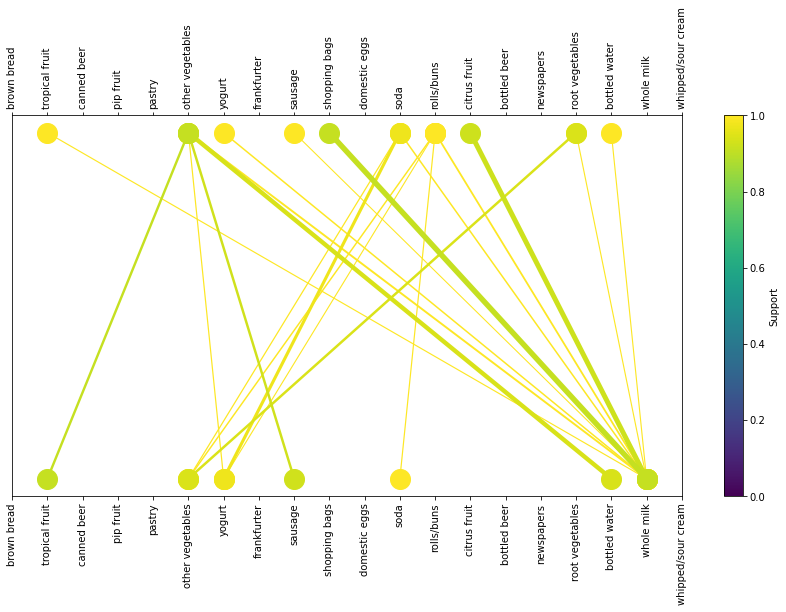

In [80]:
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
fig = plt.figure(figsize=(15,7))
for i, r in top_rules.head(20).iterrows():
    plt.plot([r['FromN'], r['ToN']], [0,1], 
            'o-',
            c=plt.cm.viridis(r['Support']*10),
            markersize=20,
            lw=r['Confidence']*10)
_ = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))
_.set_label('Support')
plt.xticks(range(len(items)), items, rotation='vertical' )
plt.yticks([])
plt.show()